# Predicting Student Performance on Final Exams

This notebook presents a solution for a machine learning problem that aims to classify students as likely to fail on the final exam or not. Such information will be helpful to identify students that may be struggling to offer additional help, and as a result it will increase the student success rate. Features exploratory data analysis and explanatory analysis of classification model predictions.

**Table of Content**
- [Setup](#Setup)
- [Data](Data)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Univariate Statistical Analysis](#Univariate-Statistical-Analysis)
- [Multivariate Statistical Analysis](#Multivariate-Statistical-Analysis)
- [Data Split](#Data-Split)
- [Modeling: Experiments](#Modeling:-Experiments)
- [Modeling: Final Model](#Modeling:-Final-Model)
- [Model Predictions Interpretation](#Model-Predictions-Interpretation)
- [Error Analysis](#Error-Analysis)
- [Possible Improvements](#Possible-Improvements)

## Setup

Import of necessary Python libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from scipy import stats
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, RobustScaler, QuantileTransformer 
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, chi2, f_classif, SelectFromModel, mutual_info_classif, RFE
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, precision_recall_curve, auc, average_precision_score, f1_score, roc_curve
from sklearn.decomposition import PCA
from sklearn import set_config
set_config(display='diagram')
import xgboost as xgb
import shap
shap.initjs()
sns.set()
from sklearn.preprocessing import PowerTransformer, MinMaxScaler, KBinsDiscretizer
from scipy.stats import boxcox
from sklearn.ensemble import IsolationForest

seed = 42

In [2]:
# optional: improves readibility by displaying all columns 
pd.set_option("display.max_columns", None)
pd.options.display.float_format = "{:.2f}".format
%matplotlib inline

## Data 
Open-source dataset: https://analyse.kmi.open.ac.uk/open_dataset

In [3]:
df = pd.read_csv("data/raw-data.csv")

In [4]:
df.head()

,Unnamed: 0,enrollment_id,code_module,code_presentation,id_student,date_registration,date_unregistration,course,module_presentation_length,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,dataplus,dualpane,externalquiz,folder,forumng,glossary,homepage,htmlactivity,oucollaborate,oucontent,ouelluminate,ouwiki,page,questionnaire,quiz,repeatactivity,resource,sharedsubpage,subpage,url,clicks_1st_quarter,clicks_2nd_quarter,clicks_3rd_quarter,clicks_4th_quarter,clicks_before_start,score,past_deadline,num_past_deadline,total_weighted_score,total_weights,num_banked
0,0,11391_AAA_2013J,AAA,2013J,11391,-159.00,nan,AAA_2013J,268,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,nan,nan,nan,nan,193.00,nan,138.00,nan,nan,553.00,nan,nan,nan,nan,nan,nan,13.00,nan,32.00,5.00,447.00,165.00,38.00,186.00,98.00,nan,nan,0.00,82.40,100.00,0.00
1,1,28400_AAA_2013J,AAA,2013J,28400,-53.00,nan,AAA_2013J,268,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,10.00,nan,nan,nan,417.00,nan,324.00,nan,nan,537.00,nan,nan,nan,nan,nan,nan,12.00,nan,87.00,48.00,508.00,225.00,360.00,127.00,215.00,nan,nan,2.00,65.40,100.00,0.00
2,2,30268_AAA_2013J,AAA,2013J,30268,-92.00,12.00,AAA_2013J,268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,nan,nan,nan,nan,126.00,nan,59.00,nan,nan,66.00,nan,nan,nan,nan,nan,nan,4.00,nan,22.00,4.00,179.00,nan,nan,nan,102.00,nan,nan,nan,nan,nan,nan
3,3,31604_AAA_2013J,AAA,2013J,31604,-52.00,nan,AAA_2013J,268,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,2.00,nan,nan,nan,634.00,1.00,432.00,nan,nan,836.00,nan,nan,nan,nan,nan,nan,19.00,nan,144.00,90.00,674.00,539.00,457.00,319.00,169.00,nan,nan,0.00,76.30,100.00,0.00
4,4,32885_AAA_2013J,AAA,2013J,32885,-176.00,nan,AAA_2013J,268,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,nan,nan,nan,nan,194.00,4.00,204.00,nan,nan,494.00,nan,nan,nan,nan,nan,nan,45.00,nan,79.00,14.00,310.00,191.00,111.00,127.00,295.00,nan,nan,5.00,55.00,100.00,0.00


## Exploratory Data Analysis

In [5]:
df.drop("Unnamed: 0", axis=1, inplace=True)

In [6]:
df.columns = ["Enrollment ID", "Code Module", "Code Presentation","Student ID", "Date Registration", 
              "Date Unregistration", "Course", "Course Length", "Gender", "Region", "Highest Education",
              "IMD Band", "Age Band", "Num Prev Attempts", "Studied Credits", "Disability", "Final Result",
              "Data Plus", "Dual Pane", "External Quiz", "Folder", "Forum Ng", "Glossary", "Homepage", 
              "HTML Activity", "OU Collaborate", "OU Content", "OU Elluminate", "OU Wiki", "Page", "Questionnaire", 
              "Quiz", "Repeatactivity", "Resource", "Shared Subpage", "Subpage", "Url", "Clicks 1Q", 
              "Clicks 2Q", "Clicks 3Q", "Clicks 4Q", "Clicks Before Start", "Score",
              "Past Deadline", "Num Past Deadline", "Total Weighted Score", "Total Weights", "Num Banked"]

#### Multiple record per enrollment

In [7]:
# Check for duplicate records per enrollment
assert len(np.unique(df["Enrollment ID"])) == len(df)

#### Irrelevant features

In [8]:
df.drop(["Student ID", "Enrollment ID", "Course", "Date Registration"], axis=1, inplace=True)

**Protected features**

In [9]:
df.drop(["Disability", 'Gender', 'Age Band'], axis=1, inplace=True)

**Data types**

In [10]:
df.dtypes.sort_values()

Course Length             int64
Num Prev Attempts         int64
Studied Credits           int64
OU Elluminate           float64
Quiz                    float64
Repeatactivity          float64
Resource                float64
Shared Subpage          float64
Subpage                 float64
Url                     float64
Clicks 1Q               float64
Clicks 3Q               float64
Questionnaire           float64
Clicks 4Q               float64
Clicks Before Start     float64
Score                   float64
Past Deadline           float64
Num Past Deadline       float64
Total Weighted Score    float64
Clicks 2Q               float64
Page                    float64
Num Banked              float64
Total Weights           float64
Date Unregistration     float64
Data Plus               float64
OU Wiki                 float64
External Quiz           float64
Folder                  float64
Dual Pane               float64
Glossary                float64
Homepage                float64
HTML Act

The dataset has 32,593 rows and 49 **attributes:**
- `Enrollment ID`: a unique enrollment identifier for a given tuple (student, code module, code presentation)
- `Code Module`: a code name of the module
- `Code Presentation`: a code name of the presentation. It consists of the year and “B” for the presentation starting in February and “J” for the presentation starting in October.
- `Student ID`: a unique identification number for the student.
- `Date Registration`: the date of student’s registration on the module presentation, this is the number of days measured relative to the start of the module-presentation, this is the number of days measured relative to the start of the module-presentation
- `Date Unregistration`: date of student unregistration from the module presentation, this is the number of days measured relative to the start of the module-presentation
- `Course`: unique course identifier for a given pair (code module, code presentation)
- `Course Length`: length of the module-presentation in days
- `Gender`: the student’s gender
- `Region`: identifies the geographic region, where the student lived while taking the module-presentation
- `Highest Education`: highest student education level on entry to the module presentation
- `IMD Band`: specifies the Index of Multiple Depravation band of the place where the student lived during the module-presentation
- `Age Band`: band of the student’s age
- `Num Prev Attempts`:  the number times the student has attempted this module
- `Studied Credits`: the total number of credits for the modules the student is currently studying
- `Disability`: indicates whether the student has declared a disability
- `Final Result`: student’s final result in the module-presentation
- `Score`: the score for the final exam
- `Past Deadline`: whether the submission of the final exam was past deadline or not
- `Data Plus`, `Dual Pane`, `External Quiz`, `Folder`, `Forum Ng`, `Glossary`, `Homepage`, `HTML Activity`, `OU Collaborate`, `OU Content`, `OU Elluminate`, `OU Wiki`, `Page`, `Questionnaire`, `Quiz`, `Repeatactivity`, `Resource`, `Shared Subpage`, `Subpage`, `Url`: sum of clicks during the course duration per site element 
- `Clicks 1Q`, `Clicks 2Q`, `Clicks 3Q`, `Clicks 4Q`, `Clicks Before Start`: sum of clicks during the course duration per quarter 
- `Num Past Deadline`: number of submissions past deadline
- `Total Weighted Score`: weighted sum of all scores received during the course
- `Total Weights`: sum of weights that reflects the percentage of assessments taken by a student 
- `Num Banked`: number of banked assessment scores 

## Univariate Statistical Analysis

### Basic descriptive statistic on numerical features

In [11]:
df.describe()

,Date Unregistration,Course Length,Num Prev Attempts,Studied Credits,Data Plus,Dual Pane,External Quiz,Folder,Forum Ng,Glossary,Homepage,HTML Activity,OU Collaborate,OU Content,OU Elluminate,OU Wiki,Page,Questionnaire,Quiz,Repeatactivity,Resource,Shared Subpage,Subpage,Url,Clicks 1Q,Clicks 2Q,Clicks 3Q,Clicks 4Q,Clicks Before Start,Score,Past Deadline,Num Past Deadline,Total Weighted Score,Total Weights,Num Banked
count,10072.00,32593.00,32593.00,32593.00,2710.00,3707.00,4882.00,1934.00,26006.00,6036.00,29185.00,1918.00,10890.00,26922.00,2501.00,10616.00,8728.00,4511.00,19973.00,3.00,27596.00,128.00,28210.00,23901.00,28359.00,23195.00,20372.00,18281.00,23809.00,4959.00,4959.00,25614.00,25614.00,25614.00,25614.00
mean,49.76,256.01,0.16,79.76,17.52,5.59,13.17,2.80,306.60,14.57,238.10,4.82,10.01,416.27,15.60,84.26,7.29,14.36,349.53,3.00,40.23,1.34,120.94,23.71,508.42,334.25,419.76,368.39,90.22,65.57,0.00,1.85,54.13,74.26,0.07
std,82.46,13.18,0.48,41.07,16.13,5.80,16.92,1.66,625.39,77.20,320.33,3.23,16.10,675.00,22.03,130.35,8.39,12.35,528.74,1.00,74.23,0.81,165.16,38.67,613.50,437.56,507.42,462.02,143.80,20.58,0.05,2.27,28.94,34.55,0.53
min,-365.00,234.00,0.00,30.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,2.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
25%,-2.00,241.00,0.00,60.00,5.00,2.00,3.00,2.00,34.00,1.00,55.00,3.00,2.00,28.00,2.00,12.00,2.00,5.00,72.00,2.50,11.00,1.00,20.00,4.00,127.00,72.00,97.00,80.00,14.00,51.00,0.00,0.00,26.83,44.00,0.00
50%,27.00,262.00,0.00,60.00,13.00,4.00,7.00,2.00,121.00,3.00,145.00,4.00,4.00,135.00,7.00,37.00,5.00,10.00,131.00,3.00,25.00,1.00,56.00,12.00,315.00,182.00,247.00,199.00,42.00,67.00,0.00,1.00,62.16,100.00,0.00
75%,109.00,268.00,0.00,120.00,26.00,8.00,17.00,4.00,326.75,9.00,304.00,6.00,12.00,501.00,20.00,100.00,10.00,20.00,528.00,3.50,50.00,1.00,161.00,30.00,663.00,417.00,561.00,495.00,108.00,82.00,0.00,3.00,78.57,100.00,0.00
max,444.00,269.00,6.00,655.00,143.00,68.00,340.00,13.00,13154.00,2952.00,7277.00,33.00,316.00,9308.00,317.00,2117.00,334.00,89.00,13032.00,4.00,5147.00,6.00,4345.00,2134.00,10149.00,6520.00,6626.00,10043.00,3731.00,100.00,1.00,12.00,100.00,100.00,11.00


### Missing values

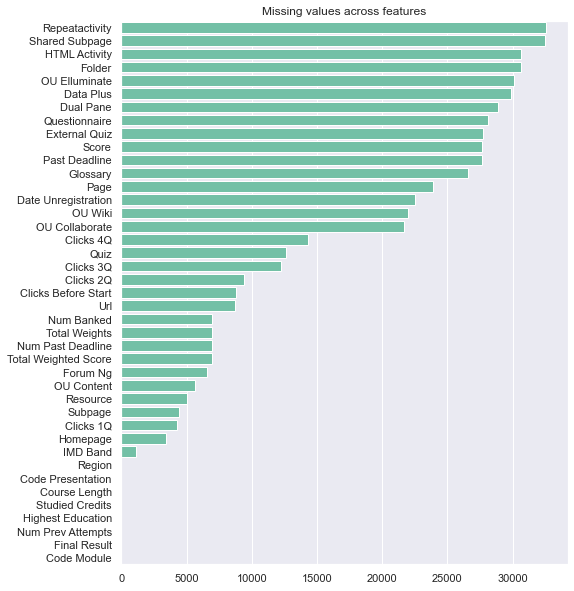

In [12]:
# Check for columns with missing values
plt.figure(figsize=(8, 10))
missing_vals = df.isnull().sum().sort_values(ascending=False)
sns.barplot(x=missing_vals, y=missing_vals.index, orient="h", color="mediumaquamarine")
plt.title("Missing values across features");

**Unregistration date**

Since this feature is related only to some part of our data, we will substitute it with a binary feature "withdrawn". We will check data coherency with target variable because it also contains information about withdrawal.

In [13]:
withdrawn = (df["Date Unregistration"].notna()) | (df["Final Result"] == "Withdrawn")
withdrawn.sum()

10165

In [15]:
df.drop(df[withdrawn].index, axis=0, inplace=True)

Boolean Series key will be reindexed to match DataFrame index.


In [16]:
df.drop("Date Unregistration", axis=1, inplace=True)

In [ ]:
# # Enrollments that were withdrawn before the course has started
# withdrawn_before_start = df[df["Date Unregistration"] <= 0]
# df.drop(withdrawn_before_start.index, inplace=True)

In [ ]:
# # Unregistered_date and final_result feature incoherent
# unregistered_date_notnan = df["Date Unregistration"].isnull() == False
# final_result_not_withdrawn = df["Final Result"] != "Withdrawn"

# len(df[unregistered_date_notnan & final_result_not_withdrawn])

In [ ]:
# # Unregistered_date and final_result feature incoherent
# len(df[~unregistered_date_notnan & ~final_result_not_withdrawn])

In [ ]:
# # Drop incoherent records
# df.drop(df[unregistered_date_notnan & final_result_not_withdrawn].index, inplace=True)
# df.drop(df[~unregistered_date_notnan & ~final_result_not_withdrawn].index, inplace=True)

# # Drop the feature
# df.drop("Date Unregistration", axis=1, inplace=True)

# # # Create a binary substitute
# df["Withdrawn"] = df["Final Result"].apply(lambda x: 1 if x == "Withdrawn" else 0)

**Features with less than 50% of data available** 

In [22]:
# Filter columns with less than 50% of values available
filter_nulls = df.isnull().mean() < 0.8
df = df.loc[:, filter_nulls]

**Index of Multiple Depravation**
- Handle missing values by imputing the mode for each region

In [23]:
# Impute IMD mode for each region
imd_mode = df.groupby("Region")["IMD Band"].agg(lambda x: x.value_counts().index[0])
imd_mode

Region
East Anglian Region     90-100%
East Midlands Region      10-20
Ireland                   10-20
London Region             10-20
North Region              10-20
North Western Region      0-10%
Scotland                 50-60%
South East Region        60-70%
South Region            90-100%
South West Region        30-40%
Wales                    20-30%
West Midlands Region      0-10%
Yorkshire Region          0-10%
Name: IMD Band, dtype: object

In [24]:
df["IMD Band"] = df.apply(lambda row: imd_mode[row["Region"]] if pd.isnull(row["IMD Band"]) 
                                                              else row["IMD Band"], axis=1)

In [25]:
df.drop("Region", axis=1, inplace=True)

**Total Weights (~ Number of tests taken)**

In [26]:
no_test_taken = np.where(df["Total Weights"].isnull())[0]
len(no_test_taken)

1367

In [27]:
df.drop(df.iloc[no_test_taken].index, axis=0, inplace=True)

**Activity of platform and performance on tests**

Activity (clicks) on virtual platform per material, per quarter and performance on tests

In [28]:
# These are the only columns left with missing values: fill with zeroes
df.fillna(0, inplace=True)

### Data distribution 

**Target variable**

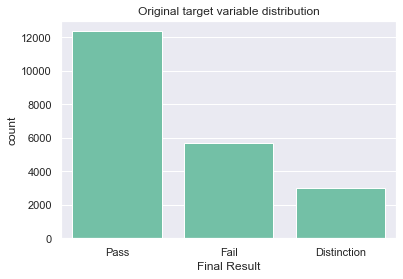

In [29]:
sns.countplot(x="Final Result", data=df, color="mediumaquamarine") 
plt.title('Original target variable distribution');

In [30]:
# Create binary target variable
df["Fail?"] = df["Final Result"].apply(lambda x: "Yes" if x == "Fail" else "No")

# Drop old target variable
df.drop("Final Result", axis=1, inplace=True)

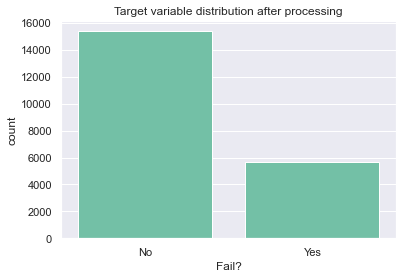

In [31]:
sns.countplot(x="Fail?", data=df, color="mediumaquamarine")
plt.title('Target variable distribution after processing');

**Numeric features**

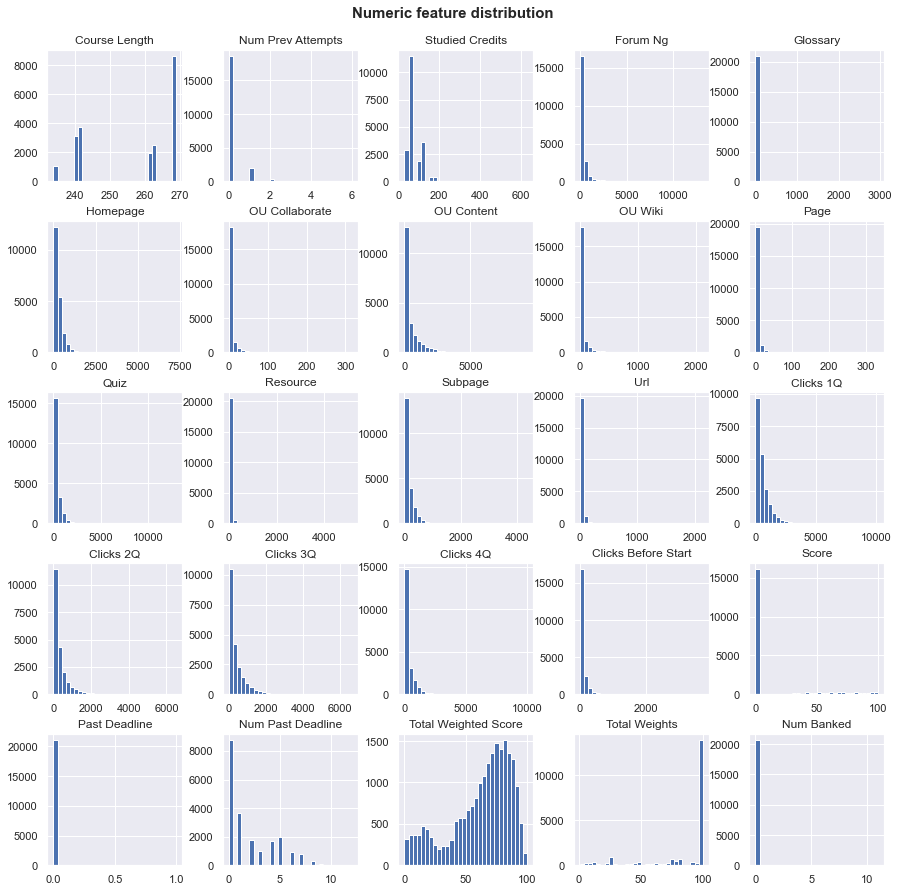

In [32]:
df.hist(bins=30, figsize=(15, 15))
plt.suptitle("Numeric feature distribution", fontweight='bold', fontsize=15, y=0.92);

In [ ]:
numeric_cols = df.select_dtypes(exclude=['object'])
for feature in numeric_cols:
    q25, q75 = np.percentile(df[feature], 25), np.percentile(df[feature], 75)
    iqr = q75 - q25
    cutoff = iqr * 1.5
    lower, upper = q25-cutoff, q75+cutoff
    
    outliers_idx = np.where((df[feature] < lower) | (df[feature] > upper)) 
    outliers = df.iloc[outliers_idx]
    
    print(f'{feature}: {len(outliers)} outliers')

In [ ]:
def filter_by_iqr(series_, k=1.5, return_thresholds=False):
    q25, q75 = np.percentile(series_, 25), np.percentile(series_, 75)
    iqr = q75-q25
    cutoff = iqr*k

    lower_bound, upper_bound = q25-cutoff, q75+cutoff
    
    if return_thresholds:
        return lower_bound, upper_bound
    else:
        return [True if i < lower_bound or i > upper_bound else False for i in series_]

In [ ]:
def bivariate_outlier_id_plot(df, list_num_features, target, n_bins=20):
    sns.set_style("darkgrid") 
    fig = plt.figure(figsize=(22, 12))
    color = "floralwhite"
    i=1
    for feature in list_num_features:
  
        ser = df[feature]
          
        # box plots
        thresholds = filter_by_iqr(ser, 1.5, True)
        outliers = df[[feature, target]][df[feature]>thresholds[1]]

        ax = fig.add_subplot(5, 4, i)

        box = ax.boxplot(ser, flierprops=dict(markerfacecolor='r', marker='s'), 
                         vert=False, patch_artist=True, sym="w")   
        
        ax.plot(outliers.iloc[:, 0][outliers.iloc[:, 1]=="No"], np.ones(sum(outliers.iloc[:, 1]=="No")), color="black", marker = "o", markersize=4)
        ax.plot(outliers.iloc[:, 0][outliers.iloc[:, 1]=="Yes"], np.ones(sum(outliers.iloc[:, 1]=="Yes")), color="red", marker = "D", markersize=6)
        ax.set_title(feature)
        box['boxes'][0].set_facecolor(color)

        i+=1
        
    fig.suptitle('Variable Distribution',  ha='center',
                     va='center', fontsize=20, y=1.03, fontweight='bold')

    plt.tight_layout()
    plt.show()

bivariate_outlier_id_plot(df, numeric_cols, "Fail?", n_bins=20)


- Most features are not normally distributed, `Date Registration` and `Studied Credits` being a notable exception.  
- `Num Prev Attempts`, `Num Banked`, `Withdrawn` should be converted to non-numeric features.
- `Resource` and `Url` should be dropped due to very low variance.

In [ ]:
# for feature in ["Num Prev Attempts", "Num Banked", 'Withdrawn']:
#     df[feature] = df[feature].astype(object)

In [ ]:
# Distribution by target
numeric_cols = df.select_dtypes(exclude=['object']).columns
for column in numeric_cols:
    df[[column, 'Fail?']].hist(by='Fail?', bins=30, sharey=True, sharex=True);
    plt.suptitle(column, size=13)
    plt.show()

In [ ]:
fig, m_axs = plt.subplots(4,4, figsize = (20, 22))
for column, ax in zip(numeric_cols, m_axs.flatten()):
    df[[column, "Fail?"]].boxplot(by="Fail?", ax=ax)
    plt.suptitle('')

**Catagorical features**

In [ ]:
categorical_cols = df.select_dtypes(include=['object']).columns
for column in categorical_cols:
    if column != 'Fail?':
        freq_table = pd.crosstab(columns=df[column],index=df['Fail?'], normalize='index')
        
        display(freq_table)
        freq_table.plot(kind='barh', stacked=True, figsize=(10,2))
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.show()

**Students who failed** on the final exam appear to:
- be more likely to have lower than A level education
- be more likely to come from a region characterized by a low IMD 
- be more likely to have attempted the module in the past at least once
- likely be under 35 
- achieve much lower scores
- be less likely to take all available tests 
- be more likely to have some grades banked
- often have withdrawn their registration
- seem to study more credits 
- less frequently use online platform resources
- show substantially less usage of online platform during the 1st quarter of the course
- show almost no usage of online platform during the 2nd, 3rd and 4th quarter of the course
- generally not use the platform before the start of the course
- be more likely to submit their assessments after deadline

## Multivariate Statistical Analysis

### Correlation  between numerical features

In [ ]:
pd.plotting.scatter_matrix(df, figsize=(20, 20))
plt.show()

Given that the correlation between numeric features is not linear and that features do not follow Gaussian distribution, we will use Spearman coefficient to measure the level of relationship between features.

In [ ]:
plt.figure(figsize=(15,10))

corr = df.corr(method="spearman")

# Mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Generate diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, annot=True, annot_kws={"fontsize":10},
            fmt=".1", linewidths=2, cbar_kws={"shrink": 0.5})
plt.title("Feature Spearman correlation")
plt.show()

In [ ]:
df.drop(["Course Length"], axis=1, inplace=True)

**High correlation between features:**
- number of clicks per quarter and number of clicks per material, eg. homepage visits, oucontent visits, forumng visits
- total weighted score and total weights
- homepage/resource/oucontent visits
- homepage visits and total weighted score/total weights/final result

In [ ]:
# df.drop(['Total Weights', "Clicks 2Q", "Clicks 3Q", "Clicks 4Q", "Homepage", "Forum Ng", 'Subpage', "OU Content"], 
#         axis=1, inplace=True)

### Correlation between categorical features

Cramer correlation coefficient since some features can have more than 2 different values, eg. imd_band can have 10 different values. 

In [ ]:
features_paired = [(i,j) for i in df[categorical_cols].columns.values for j in df[categorical_cols].columns.values] 
phi2 = []

for f in features_paired:
    crosstab = pd.crosstab(df[f[0]], df[f[1]]) 
    chi2test = stats.chi2_contingency(crosstab)
    phi2.append(chi2test[0] / len(df)) # phi2 
    
# Shape a matrix
num_features = len(categorical_cols)
phi2 = np.array(phi2).reshape((num_features, num_features)) 
# Shape a DataFrame
phi2 = pd.DataFrame(phi2, index=df[categorical_cols].columns.values, columns=df[categorical_cols].columns.values) 

In [ ]:
# Mask for the upper triangle
mask = np.triu(np.ones_like(phi2, dtype=np.bool))

plt.figure(figsize=(10,7))
sns.heatmap(phi2, mask=mask, cmap=cmap, center=0, annot=True, annot_kws={"fontsize":10},
            fmt=".1", linewidths=2, cbar_kws={"shrink": 0.5})
plt.show()

In [ ]:
df["IMD > 50%"] = df["IMD Band"].apply(lambda x: 0 if x in(["0-10%", "10-20", "20-30%", "30-40%", "40-50%"]) else 1)

In [ ]:
df.drop("IMD Band", axis=1, inplace=True)

There is a correlation between region and the Index of Depravation index, which we know depends on the region. The correlation between "withdrawn" and final result is also straightforward. There is also some correlation between gender and the course. Let's take a closer look at it.

In [ ]:
# df.drop(["Disability", "Highest Education"], axis=1, inplace=True)

In [ ]:
# df.drop(["Age Band"], axis=1, inplace=True)

### Export data

In [ ]:
df.to_csv('dataset-student-performance.csv', index=False)

## Data Split

In [ ]:
# Move target to the end
df["Class"] = df["Fail?"].apply(lambda x: 1 if x == "Yes" else 0)
df.drop("Fail?", axis=1, inplace=True)

In [ ]:
X, Y = df.iloc[:,:-1], df.iloc[:,-1]

In [ ]:
# Split data into train and test sets
test_size = 0.2
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify=Y, test_size=test_size, random_state=seed)

## Modeling: Experiments

In [ ]:
def get_pipeline(X_train):

    numeric_cols = X_train.select_dtypes(exclude=[object]).columns
    categorical_cols = X_train.select_dtypes(include=[object]).columns
# #     discrete_cols = X_train.select_dtypes(include=[int]).columns
#     print(numeric_cols)
#     print(categorical_cols)
#     print(discrete_cols)
    
    numeric_transformer = Pipeline(steps=[
               ('MinMaxScaler', MinMaxScaler()),
               ('StdScaler', StandardScaler()),
               ('RobScaler', RobustScaler()), 
               ('QTrans', QuantileTransformer(n_quantiles=100, output_distribution='normal')),
               ('PCA', PCA(n_components=7))])
    
#     discrete_transformer = Pipeline(steps=[('KBins', KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile'))])
    
    categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop="first"))]) 

    
    feature_selector = [('SelFromModel', SelectFromModel(estimator=XGBClassifier())),
                        ('SelKBest', SelectKBest()),
                        ("RFE", RFE(XGBClassifier()))]
    

    models = [('RandomForest', RandomForestClassifier()),
              ('XGBoost', XGBClassifier())]
    
    variants = [(i,j,k) for i in numeric_transformer for j in feature_selector for k in models] 
    
    for variant in variants:
        
        (num_transformer, selector, model) = variant
        
        preprocessor = ColumnTransformer(transformers=[('num', num_transformer, numeric_cols),
#                                                        ('disc', discrete_transformer, discrete_cols),
                                                       ('cat', categorical_transformer, categorical_cols)])
        pipe = Pipeline([('preprocessor', preprocessor),
                         ('selector', selector[1]),
                         ('classifier', model[1])])
                        
        yield pipe, num_transformer, selector[0], model[0]
        

In [ ]:
def test_performance(Y_test, y_pred, df):
    
    precision, recall, thresholds = precision_recall_curve(Y_test, y_pred)
    f1_scores = [f1_score(Y_test, (y_pred > thresholds[i])) for i in range(len(thresholds))]
    thresh_idx = np.argmax(f1_scores)
    thresh = thresholds[thresh_idx]
    
    df["test_accuracy"] = accuracy_score(Y_test, y_pred>thresh)
    df["test_recall"] = recall[thresh_idx]
    df["test_precision"] = precision[thresh_idx]
    df["test_auc"] = roc_auc_score(Y_test, y_pred)
    df["threshold"] = thresh
    df["test_f1score"] = f1_scores[thresh_idx]
    
    return df

In [ ]:
def run_experiments(X_train, Y_train, X_test, Y_test):

    dfs = []
    
    for (pipe, transformer, selector, model) in get_pipeline(X_train):

        # Train
        pipe.fit(X_train, Y_train)
        
        # Validate
        cv_results = cross_validate(pipe, X_train, Y_train, cv=5, scoring='accuracy')
        for k, v in cv_results.items():
            cv_results[k] = [v.mean()]
        
        cv_results["val_accuracy"] = cv_results.pop("test_score")
        df = pd.DataFrame(cv_results)
        df['model'] = model
        
        # Test
        y_pred = pipe.predict_proba(X_test)[:, 1]
        df = test_performance(Y_test, y_pred, df)
        dfs.append(df)        
        
        # Report performance
        print(f'{model} & {transformer} & {selector} \
                Mean val acc: {cv_results["val_accuracy"][0]:.3f}, Test acc: {df["test_accuracy"][0]:.3f}')
    
    # To dataframe 
    results_table = pd.concat(dfs, ignore_index=True)
    results_table.sort_values("test_accuracy", inplace=True, ascending=False)
    
    return results_table, pipe

In [ ]:
results, pipe  = run_experiments(X_train, Y_train, X_test, Y_test)
results

In [ ]:
plt.figure(figsize=(10, 5))
for col in ["val_recall", "val_f1score", "test_recall", "test_f1score"]: 
    sns.scatterplot(x="model", y=col, data=results, label=col, s=150, marker="d")
    plt.legend()
plt.ylabel("Performance")
plt.title('Comparison of Model by Classification Metric')
plt.show()

## Modelling: Final model

In [ ]:
numeric_cols = X_train.select_dtypes(exclude=[object]).columns
categorical_cols = X_train.select_dtypes(include=[object]).columns
    
numeric_transformer = Pipeline(steps=[('RobScaler', RobustScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop="first"))]) 

preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_cols),
                                               ('cat', categorical_transformer, categorical_cols)])
    
pipe = Pipeline([('preprocessor', preprocessor),
#                  ('feature_selection', SelectFromModel(estimator=XGBClassifier())), # threshold="median"
                 ('classifier', XGBClassifier())]) 
pipe.fit(X_train, Y_train)

In [ ]:
# Cross-validate 
metrics = ['accuracy', 'roc_auc', 'precision', 'recall', 'f1']
cv_results = cross_validate(pipe, X_train, Y_train, cv=3, scoring='accuracy')
# for k, v in cv_results.items():
#     cv_results[k] = [v.mean()]

# Test
y_pred = pipe.predict_proba(X_test)[:, 1]

In [ ]:
# Calculate Receiver Operating Characteristic curve (ROC) (points + thresholds)
fpr, tpr, thresholds = roc_curve(Y_test, y_pred.ravel(), pos_label=1)

# Calculate area under the curve (AUC)
auc_score = auc(fpr, tpr)

# Plot ROC curve 
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC={auc_score:.2f})' )
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate (1-Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Average precision summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold
avg_precision = average_precision_score(Y_test, y_pred)

precision, recall, thresholds = precision_recall_curve(Y_test, y_pred)

plt.plot(recall, precision, label=f'Model (AP={avg_precision:.2f})', marker='.')
plt.plot([0, 1], [0, 0], linestyle='--', label='Dummy Classifier')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("Precision-Recall curve")
plt.legend()
plt.show()

In [ ]:
# Plot F1-score on different thresholds
f1_scores = [f1_score(Y_test, (y_pred > thresholds[i])) for i in range(len(thresholds))]
accuracies = [accuracy_score(Y_test, (y_pred > thresholds[i])) for i in range(len(thresholds))]

# Choose the threshold that optimizes F1-score
thresh_idx = np.argmax(accuracies)
thresh = thresholds[thresh_idx]

plt.plot(thresholds, f1_scores, label=f'Optimal threshold = {thresh:.2f}')
plt.xlabel('Threshold')
plt.ylabel('F1-score')
plt.title('F1-score on different thresholds')
plt.legend(loc="lower left")
plt.show()

In [ ]:
# Report performance on validation sets
# cv_results["val_accuracy"] = cv_results.pop("test_accuracy")
# cv_results["val_roc_auc"] = cv_results.pop("test_roc_auc")
# cv_results["val_precision"] = cv_results.pop("test_precision")       
# cv_results["val_recall"] = cv_results.pop("test_recall")
# cv_results["val_f1score"] = cv_results.pop("test_f1")
df_performance = pd.DataFrame(cv_results)

# Report performance on test set
df_performance["test_accuracy"] = accuracy_score(Y_test, y_pred>thresh)
df_performance["test_recall"] = recall[thresh_idx]
df_performance["test_precision"] = precision[thresh_idx]
df_performance["test_auc"] = auc_score
df_performance["threshold"] = thresh
df_performance["test_f1score"] = f1_scores[thresh_idx]
pd.options.display.float_format = "{:.3f}".format
df_performance

In [ ]:
# TN FP
# FN TP
confusion_matrix(Y_test, y_pred > thresh) 

## Model Predictions Interpretation 

Since shap.TreeExplainer does not support pipe, we will manually define the XGBClassifier.

In [ ]:
# Preprocessor: train set
pipe[0].fit(X_test)
X_train_preprocessed = pipe[0].transform(X_test) # 28 columns

# Feature selector: train set
pipe[1].fit(X_train_preprocessed, Y_test)
X_train_filtered = pipe[1].transform(X_train_preprocessed) # 52 columns

In [ ]:
# Preprocessor: test set
X_test_preprocessed = pipe[0].transform(X_test)

# Feature selector: test set
X_test_filtered = pipe[1].transform(X_test_preprocessed)

In [ ]:
onehot_cols = pipe.named_steps['preprocessor'].transformers_[1][1]\
                  .named_steps['onehot'].get_feature_names(categorical_cols)

# Featured returned by preprocessor
preprocessed_cols = numeric_cols.append(pd.Index(onehot_cols))

# Boolean mask
features_selected = pipe[1].get_support() # one-hot features selected

# Featured returned by feature selector
preprocessed_cols[features_selected] 

In [ ]:
# Fit the model 
model = xgb.XGBClassifier()
model.fit(X_train_filtered, Y_test)

In [ ]:
# Two samples (1 positive and 1 negative)
X_test.iloc[0:2, :]

In [ ]:
# Groud truth 
Y_test.iloc[0:2]

In [ ]:
# Predictions 
(y_pred[0:2] > thresh).astype(int)

<span style="background-color: #BFE1BE"> 
True Negative Example
- **In favor of pass**: high total_weighted_score, high number of click in 4th quarter, high url clicks, course other than FFF
- **In favor of fail:** course length 

In [ ]:
X_test.iloc[0:2, :]

In [ ]:
# Shapley values for a single test sample idx=0 (pass)
idx = 0
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_filtered)
shap.force_plot(explainer.expected_value, shap_values[idx], features=X_test_filtered[idx], 
                feature_names=preprocessed_cols[features_selected])

In [ ]:
# Shapley values for a single test sample idx=0 (fail)
idx = 1
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_filtered)
shap.force_plot(explainer.expected_value, shap_values[idx], features=X_test_filtered[idx], 
                feature_names=preprocessed_cols[features_selected])

<span style="background-color: #BFE1BE"> 
True Positive Example
- **In favor of pass**: high total_weighted_score, high number of click in 3rd quarter
- **In favor of fail:** withdrawn, low number of clicks in 4th quarter, high number of clicks in 1st quarter


In [ ]:
shap.summary_plot(shap_values, features=X_test_filtered, feature_names=preprocessed_cols[features_selected])

## Error Analysis: students who failed the exam
Students who failed the exam correctly classified  vs. students who failed the exam incorrectly classified

In [ ]:
X_test["Prediction"] = (y_pred > thresh).astype(int)
post_df = pd.concat([X_test, Y_test], axis=1)
post_df["Outcome"] = post_df.apply(lambda row: "TP" if (row["Class"] == 1) & (row["Prediction"] == 1) else
                                                        "TN" if (row["Class"] == 0) & (row["Prediction"] == 0) else
                                                        "FN" if (row["Class"] == 1) & (row["Prediction"] == 0) else "FP",
                                                           axis=1)           

In [ ]:
# Numeric features 
numeric_cols = post_df.select_dtypes(exclude=[object]).columns  

# Categorical features
categorical_cols = post_df.select_dtypes(include=[object]).columns

In [ ]:
# Check numerical features' distribution
filter_fail = post_df["Class"] == 1
fig, m_axs = plt.subplots(6,3, figsize = (20, 25))
for column, ax in zip(numeric_cols, m_axs.flatten()):
    sns.boxplot(x="Outcome", y=column, data=post_df[filter_fail], ax=ax)  

Students who failed the exam that were incorrectly classified:
- used online platform often
- very often submitted their assessments after deadline 
- received relatively high weighted score from assessments
- usually took all tests

In [ ]:
categorical_cols = df.select_dtypes(include=['object']).columns
for column in categorical_cols:

    freq_table = pd.crosstab(columns=post_df[filter_negatives][column], 
                             index=post_df[filter_negatives]['Outcome'], 
                             normalize='index')

    display(freq_table)
    freq_table.plot(kind='barh', stacked=True, figsize=(10,2))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

In [ ]:
fig, m_axs = plt.subplots(3, 2, figsize = (15, 15))
for column, ax in zip(categorical_cols, m_axs.flatten()):
    sns.countplot(y=column, hue="confusion_matrix", data=post_df[filter_negatives], ax=ax, orient="h")
    ax.set_title(str(column)+' distribution')

## Possible Improvements

* Binning of categorical features
* Error analysis of false negatives and further feature transformation
* Consider true cost of erroneous classification (FP and FN) and choose an adequate metric (recall / precision)
* Tune model hyperparameters further with probabilistic techniques (bayesian optimization with Optuna / HyperOpt)
